In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pandemictest/test.csv


In [1]:
!pip install pymorphy2
!pip install pymystem3

     |████████████████████████████████| 55 kB 652 kB/s eta 0:00:011
     |████████████████████████████████| 8.2 MB 8.5 MB/s eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=f7fb7b3fd1172fbfd35da06cf504d4e3703985b064a9f822e3ad1e63513b4cfd
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.decomposition import TruncatedSVD
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem
import pymorphy2
from datetime import date, timedelta, datetime
from tqdm import tqdm

In [9]:
m = Mystem()
#test = pd.read_csv('/kaggle/input/pandemictest/test.csv', delimiter=';')
# test.creation_date = test.creation_date.astype('datetime64')
# test.modification_date = test.modification_date.astype('datetime64')
# test.publish_date = test.publish_date.astype('datetime64')
columns = ['position','region','industry','locality_name','education_type']
columns = ['position_industry', 'position_industry_region',
       'position_industry_region_locality', 'region_locality_name',
       'schedule_employement_type','institution']

for column_name in columns:
    item_name = test[['id', column_name]].drop_duplicates()
    lemmatizer = WordNetLemmatizer()
    dim = 50
    m = Mystem()
    data = test[['id', column_name]].drop_duplicates()  # Создаем недублированные наименования товаров
    patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]"  # Строка для удаления символов и цифр
    morph = pymorphy2.MorphAnalyzer()
    for i, num_i in tqdm(enumerate(data[column_name].values)):  # Цикл лемматизации
        tmp = str(num_i).lower().split(' ')  # Разделяем наименование товара по пробелу
        for j, num_j in enumerate(tmp):  # Цикл перебора всех слов находящихся в наименовании товара
            tmp[j] = morph.parse(num_j)[0].normal_form  # Приведение к начальной форме слова русского языка
            try:
                tmp[j] = m.lemmatize(num_j)[0]  # Приведение к начальной форме слова английского языка
            except:
                if tmp[j] == '':
                    pass
                else:
                    tmp[j] = m.lemmatize(num_j)  # Исключения для слов с единственной начальной формой слова
        tmp = re.sub(patterns, ' ', ' '.join(tmp)).replace('«', ' ').replace(',', ' ').replace(
            '#', '').replace('    ', ' ').replace('  ', ' ').replace('  ', ' ').replace(
            '  ', ' ').replace('  ', ' ').replace('\n','')  # Обработка слов (убираем слова не несущие никакой смысловой нагрузки, а также редкие символы)
        try:
            if tmp[0] == ' ':  # Убираем пробел в начале предложения если он есть
                tmp = tmp[1:]
            if tmp[-1] == ' ':  # Убираем пробел в конце предложения если он есть
                tmp = tmp[:-1]
        except:
            pass
        data[column_name].values[i] = tmp  # Сохраняем в DF измененное предложение
        
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data[column_name])
    lda_dim = 50
    lda = LatentDirichletAllocation(n_components=lda_dim)
    item_name_feats = lda.fit_transform(X)
    item_name_feats = pd.DataFrame(item_name_feats, columns=['type_' + column_name + '_' + str(i) for i in range(lda_dim)])
    data.reset_index(inplace=True)
    del data['index']

    for item_i in item_name_feats.columns:
        data[item_i] = item_name_feats[item_i]

    del test[column_name]
    test = pd.merge(data, test, on='id')
    test.to_pickle('test.pkl')

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
131259it [07:39, 285.84it/s]
131259it [11:02, 198.23it/s]
131259it [11:28, 190.56it/s]
131259it [04:28, 489.31it/s]
131259it [05:47, 377.70it/s]
131259it [05:29, 398.02it/s]


In [18]:


from sklearn.preprocessing import LabelEncoder

test['citizenship_code'] = LabelEncoder().fit_transform(test.citizenship)
test.gender = test.gender.fillna('Unknow')
test['gender_code'] = LabelEncoder().fit_transform(test.gender)

a = []
b = []
c = []
d = []
e = []
for i in test.drive_licences.values:
    try:
        temp = i.replace('[', '').replace(']', '').replace('  ', '').replace(' ', '').split(',')
        temp_abc = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
        for j in temp:
            temp_abc[j] = 1
        a += [temp_abc['A']]
        b += [temp_abc['B']]
        c += [temp_abc['C']]
        d += [temp_abc['D']]
        e += [temp_abc['E']]
    except:
        a += [0]
        b += [0]
        c += [0]
        d += [0]
        e += [0]


test['drive_A'] = a
test['drive_B'] = b
test['drive_C'] = c
test['drive_D'] = d
test['drive_E'] = e




In [8]:
test['del_mod_cre']=test.modification_date - test.creation_date
test['del_mod_pub']=test.modification_date - test.publish_date


In [40]:
str(test.modification_date.values[0]).split('T')[0].split('-')[2]
year = []
month = []
day = []
for i in test.publish_date.values:
    year += [str(i).split('T')[0].split('-')[0]]
    month += [str(i).split('T')[0].split('-')[1]]
    day += [str(i).split('T')[0].split('-')[2]]

test['pub_year'] = year
test['pub_month'] = month
test['pub_day'] = day

test = test.sort_values('publish_date')
train = train.sort_values('publish_date')
del test['day_num']
check_data = train.publish_date.drop_duplicates()
check_data = check_data.reset_index()
del check_data['index']
check_data = check_data.reset_index()
check_data.columns = ['day_num', 'publish_date']
test = pd.merge(check_data, test, on='publish_date', how='right')
test.day_num = test.day_num.fillna(0)

,day_num,publish_date,id,institution,type_institution_0,type_institution_1,type_institution_2,type_institution_3,type_institution_4,type_institution_5,...,day_year,vm_schedule,prd_schedule,cg_schedule,gg_schedule,nrd_schedule,neprd_schedule,employement_type_code,employement_type_code_enc,gender_code_enc
0,0.0,2015-06-21,174741,nan,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,172,1,1,0,0,0,0,1,1.161579,2.000000
1,0.0,2015-07-06,339043,калининский сельскохозяйственный институт,0.007677,0.007677,0.007677,0.007677,0.007677,0.007677,...,187,0,1,1,0,0,0,1,1.082430,1.388889
2,0.0,2015-07-07,100508,днепропетровскйй государственный университет,0.008622,0.008622,0.008622,0.008622,0.008622,0.008622,...,188,0,1,0,0,0,0,1,1.058252,0.000000
3,0.0,2015-07-09,359900,гоу спо красноярский автотранспортный техникум,0.006266,0.006266,0.006266,0.346319,0.006266,0.006266,...,190,0,1,0,1,1,1,1,1.161579,1.483871
4,3.0,2015-07-11,239113,мтуся,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,192,0,1,0,0,0,0,1,1.161579,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,1888.0,2020-12-13,223985,юсхт,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,348,0,1,0,0,0,0,1,1.000000,1.248427
131255,1888.0,2020-12-13,410704,вологодский государственный технический универ...,0.007209,0.646761,0.007209,0.007209,0.007209,0.007209,...,348,0,1,0,0,0,0,1,1.098413,1.285182
131256,1888.0,2020-12-13,124978,оренбургский государственный торговый экономич...,0.006518,0.006518,0.006518,0.006518,0.006518,0.006518,...,348,0,1,0,0,0,0,1,1.110588,1.530094
131257,1889.0,2020-12-14,172402,ярославский государственный педагогический уни...,0.006243,0.006243,0.006243,0.006243,0.006243,0.006243,...,349,0,1,0,0,0,0,1,1.198052,1.407809


In [12]:
data=test[['day_num', 'id', 'type_education_type_0',
       'type_education_type_1', 'type_education_type_2',
       'type_education_type_3', 'type_education_type_4',
       'type_education_type_5', 'type_education_type_6',
       'type_education_type_7', 'type_education_type_8',
       'type_education_type_9', 'type_education_type_10',
       'type_education_type_11', 'type_education_type_12',
       'type_education_type_13', 'type_education_type_14',
       'type_education_type_15', 'type_education_type_16',
       'type_education_type_17', 'type_education_type_18',
       'type_education_type_19', 'type_education_type_20',
       'type_education_type_21', 'type_education_type_22',
       'type_education_type_23', 'type_education_type_24',
       'type_education_type_25', 'type_education_type_26',
       'type_education_type_27', 'type_education_type_28',
       'type_education_type_29', 'type_education_type_30',
       'type_education_type_31', 'type_education_type_32',
       'type_education_type_33', 'type_education_type_34',
       'type_education_type_35', 'type_education_type_36',
       'type_education_type_37', 'type_education_type_38',
       'type_education_type_39', 'type_education_type_40',
       'type_education_type_41', 'type_education_type_42',
       'type_education_type_43', 'type_education_type_44',
       'type_education_type_45', 'type_education_type_46',
       'type_education_type_47', 'type_education_type_48',
       'type_education_type_49', 'type_locality_name_0',
       'type_locality_name_1', 'type_locality_name_2',
       'type_locality_name_3', 'type_locality_name_4',
       'type_locality_name_5', 'type_locality_name_6',
       'type_locality_name_7', 'type_locality_name_8',
       'type_locality_name_9', 'type_locality_name_10',
       'type_locality_name_11', 'type_locality_name_12',
       'type_locality_name_13', 'type_locality_name_14',
       'type_locality_name_15', 'type_locality_name_16',
       'type_locality_name_17', 'type_locality_name_18',
       'type_locality_name_19', 'type_locality_name_20',
       'type_locality_name_21', 'type_locality_name_22',
       'type_locality_name_23', 'type_locality_name_24',
       'type_locality_name_25', 'type_locality_name_26',
       'type_locality_name_27', 'type_locality_name_28',
       'type_locality_name_29', 'type_locality_name_30',
       'type_locality_name_31', 'type_locality_name_32',
       'type_locality_name_33', 'type_locality_name_34',
       'type_locality_name_35', 'type_locality_name_36',
       'type_locality_name_37', 'type_locality_name_38',
       'type_locality_name_39', 'type_locality_name_40',
       'type_locality_name_41', 'type_locality_name_42',
       'type_locality_name_43', 'type_locality_name_44',
       'type_locality_name_45', 'type_locality_name_46',
       'type_locality_name_47', 'type_locality_name_48',
       'type_locality_name_49', 'type_industry_0',
       'type_industry_1', 'type_industry_2', 'type_industry_3',
       'type_industry_4', 'type_industry_5', 'type_industry_6',
       'type_industry_7', 'type_industry_8', 'type_industry_9',
       'type_industry_10', 'type_industry_11', 'type_industry_12',
       'type_industry_13', 'type_industry_14', 'type_industry_15',
       'type_industry_16', 'type_industry_17', 'type_industry_18',
       'type_industry_19', 'type_industry_20', 'type_industry_21',
       'type_industry_22', 'type_industry_23', 'type_industry_24',
       'type_industry_25', 'type_industry_26', 'type_industry_27',
       'type_industry_28', 'type_industry_29', 'type_industry_30',
       'type_industry_31', 'type_industry_32', 'type_industry_33',
       'type_industry_34', 'type_industry_35', 'type_industry_36',
       'type_industry_37', 'type_industry_38', 'type_industry_39',
       'type_industry_40', 'type_industry_41', 'type_industry_42',
       'type_industry_43', 'type_industry_44', 'type_industry_45',
       'type_industry_46', 'type_industry_47', 'type_industry_48',
       'type_industry_49', 'type_region_0', 'type_region_1',
       'type_region_2', 'type_region_3', 'type_region_4', 'type_region_5',
       'type_region_6', 'type_region_7', 'type_region_8', 'type_region_9',
       'type_region_10', 'type_region_11', 'type_region_12',
       'type_region_13', 'type_region_14', 'type_region_15',
       'type_region_16', 'type_region_17', 'type_region_18',
       'type_region_19', 'type_region_20', 'type_region_21',
       'type_region_22', 'type_region_23', 'type_region_24',
       'type_region_25', 'type_region_26', 'type_region_27',
       'type_region_28', 'type_region_29', 'type_region_30',
       'type_region_31', 'type_region_32', 'type_region_33',
       'type_region_34', 'type_region_35', 'type_region_36',
       'type_region_37', 'type_region_38', 'type_region_39',
       'type_region_40', 'type_region_41', 'type_region_42',
       'type_region_43', 'type_region_44', 'type_region_45',
       'type_region_46', 'type_region_47', 'type_region_48',
       'type_region_49', 'type_position_0', 'type_position_1',
       'type_position_2', 'type_position_3', 'type_position_4',
       'type_position_5', 'type_position_6', 'type_position_7',
       'type_position_8', 'type_position_9', 'type_position_10',
       'type_position_11', 'type_position_12', 'type_position_13',
       'type_position_14', 'type_position_15', 'type_position_16',
       'type_position_17', 'type_position_18', 'type_position_19',
       'type_position_20', 'type_position_21', 'type_position_22',
       'type_position_23', 'type_position_24', 'type_position_25',
       'type_position_26', 'type_position_27', 'type_position_28',
       'type_position_29', 'type_position_30', 'type_position_31',
       'type_position_32', 'type_position_33', 'type_position_34',
       'type_position_35', 'type_position_36', 'type_position_37',
       'type_position_38', 'type_position_39', 'type_position_40',
       'type_position_41', 'type_position_42', 'type_position_43',
       'type_position_44', 'type_position_45', 'type_position_46',
       'type_position_47', 'type_position_48', 'type_position_49',
       'locality', 'age', 'experience',
       'salary_desired',
        'completeness_rate', 'citizenship_code',
       'gender_code', 'drive_A', 'drive_B', 'drive_C', 'drive_D',
       'drive_E', 'pub_year', 'pub_month', 'pub_day']]
# 'del_mod_cre', 'del_mod_pub',
data.pub_year = data.pub_year.astype('int64')
data.pub_month = data.pub_month.astype('int64')
data.pub_day = data.pub_day.astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131259 entries, 0 to 131258
Columns: 267 entries, day_num to pub_day
dtypes: float64(252), int64(15)
memory usage: 268.4 MB


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
before_vectorize_df = pd.read_pickle('/kaggle/input/testpandemic/before_vectorize_df.pkl')
half_clean_train = pd.read_pickle('/kaggle/input/testpandemic/half_clean_train.pkl')
train = pd.read_pickle('../input/testpandemic/train (2).pkl')
test = pd.read_pickle('/kaggle/input/testpandemic/test (6).pkl')
education_mult_df = pd.read_pickle('/kaggle/input/testpandemic/education_mult_df')
custom_features_train_df = pd.read_pickle('../input/testpandemic/custom_features_train_df')
before_vectorize_df_1912 = pd.read_pickle('../input/testpandemic/before_vectorize_df_1912')
clean_test_df_1912 = pd.read_pickle('../input/testpandemic/clean_test_df_1912')
clean_train_1912 = pd.read_pickle('../input/testpandemic/clean_train_1912')
custom_features_test_df_1912 = pd.read_pickle('../input/testpandemic/custom_features_test_df_1912')
train.columns.values
train.employement_type



clean_test_df_1912 = clean_test_df_1912.append(test[test.completeness_rate.isna()][['id', 'position', 'region', 'industry', 'locality', 'locality_name',
       'education_type', 'drive_licences', 'citizenship', 'schedule',
       'employement_type', 'age', 'gender', 'experience', 'salary_desired',
       'relocation_ready', 'travel_ready', 'retraining_ready',
       'is_worldskills_participant', 'has_qualifications', 'completeness_rate',
       'creation_date', 'modification_date', 'publish_date']], ignore_index=True)

time_diff_df = pd.read_pickle('/kaggle/input/testpandemic/time_diff_df.pkl')

#train = pd.merge(train, half_clean_train['id'].drop_duplicates(), on='id', how='right')
train['position_industry'] = before_vectorize_df_1912['position_industry']
train['position_industry_region']=before_vectorize_df_1912['position_industry_region']
train['position_industry_region_locality']=before_vectorize_df_1912['position_industry_region_locality']
train['region_locality_name']=before_vectorize_df_1912['region_locality_name']
train['schedule_employement_type']=before_vectorize_df_1912['schedule_employement_type']


test['position_industry'] = custom_features_test_df_1912['position_industry']
test['position_industry_region']=custom_features_test_df_1912['position_industry_region']
test['position_industry_region_locality']=custom_features_test_df_1912['position_industry_region_locality']
test['region_locality_name']=custom_features_test_df_1912['region_locality_name']
test['schedule_employement_type']=custom_features_test_df_1912['schedule_employement_type']

train = pd.merge(train, education_mult_df, on='id', how='left')
test = pd.merge(test, education_mult_df, on='id', how='left')
train.columns.values

,id,position,region,industry,locality,locality_name,education_type,drive_licences,citizenship,schedule,...,relocation_ready,travel_ready,retraining_ready,is_worldskills_participant,has_qualifications,completeness_rate,creation_date,modification_date,publish_date,salary
0,0,Специалист,Тульская область,"Государственная служба, некоммерческие организ...",7100000100000,Тула,Незаконченное высшее,[B],Российская Федерация,Полный рабочий день,...,False,False,True,NaN,True,64.0,2020-05-07,2020-05-08,2020-05-07,37500
1,1,Лаборант,Алтайский край,"Государственная служба, некоммерческие организ...",2200000100000,Барнаул,Высшее,[B],Российская Федерация,Полный рабочий день,...,False,True,True,NaN,True,88.0,2020-10-21,2020-10-27,2020-10-27,14000
2,3,"Специалист, администратор, бухгалтер, экономист",Ульяновская область,"Административная работа, секретариат, АХО",7300000200000,Димитровград,Высшее,[B],Российская Федерация,Полный рабочий день,...,False,True,True,NaN,True,78.0,2019-04-25,2020-02-04,2020-02-04,24600
3,4,Специалист,Свердловская область,"Государственная служба, некоммерческие организ...",6600002300000,Нижний Тагил,Высшее,[B],Российская Федерация,Полный рабочий день,...,False,False,False,NaN,True,91.0,2020-09-19,2020-09-20,2020-09-19,16075
4,5,Инструктор по плаванию,Иркутская область,"Здравоохранение, спорт, красота, социальное об...",3800000400000,Ангарск,Высшее,NaN,Российская Федерация,Полный рабочий день,...,False,True,True,NaN,True,58.0,2020-04-20,2020-09-09,2020-04-21,22080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306265,437521,Продавец консультант.,Забайкальский край,"Продажи, закупки, снабжение, торговля",7500100000200,Александровка,Среднее,NaN,Российская Федерация,"Полный рабочий день,Сменный график",...,False,False,False,NaN,True,66.0,2020-05-02,2020-05-05,2020-05-04,27600
306266,437522,менеджер,Тюменская область,"Государственная служба, некоммерческие организ...",7201100100000,Ишим,Высшее,"[B, C]",Российская Федерация,Полный рабочий день,...,False,True,True,NaN,True,68.0,2020-04-17,2020-04-20,2020-04-20,22000
306267,437523,Руководитель,Калининградская область,Юриспруденция,3900600100000,Зеленоградск,Высшее,[B],Российская Федерация,Полный рабочий день,...,True,True,True,NaN,True,58.0,2016-11-21,2019-05-16,2016-12-08,97165
306268,437524,инженер,Ивановская область,Производство,3700000100000,Иваново,Высшее,[B],Российская Федерация,Полный рабочий день,...,False,False,True,NaN,True,78.0,2020-06-02,2020-06-03,2020-06-02,27600


In [ ]:
train = pd.merge(train, clean_train_1912['id'].drop_duplicates(), on='id', how='right')
for i in clean_train_1912.columns:
    

In [13]:
from datetime import date, timedelta, datetime
weekday=[]
for i in train['publish_date'].values:
    weekday += [datetime.strptime(str(i)[:-3],"%Y-%m-%dT%H:%M:%S.%f").isoweekday()]
train['weekday'] = weekday

weekday=[]
for i in test['publish_date'].values:
    weekday += [datetime.strptime(str(i)[:-3],"%Y-%m-%dT%H:%M:%S.%f").isoweekday()]
test['weekday'] = weekday

day_year = []
for i in train['publish_date']:
    day_year += [int(f"{i:%j}")]
train['day_year'] = day_year

day_year = []
for i in test['publish_date']:
    day_year += [int(f"{i:%j}")]
test['day_year'] = day_year

In [14]:
from sklearn.preprocessing import LabelEncoder

#'Вахтовый метод', 'Полный рабочий день','Сменный график','Гибкий график','Ненормированный рабочий день', 'Неполный рабочий день'

train.schedule.unique()
a = []
b = []
c = []
d = []
e = []
f = []
for i in train.schedule.values:
    try:
        temp = i.replace('[', '').replace(']', '').split(',')
        temp_abc = {'Вахтовый метод': 0, 'Полный рабочий день': 0, 'Сменный график': 0, 'Гибкий график': 0, 'Ненормированный рабочий день': 0,'Неполный рабочий день':0}
        for j in temp:
            temp_abc[j] = 1
        a += [temp_abc['Вахтовый метод']]
        b += [temp_abc['Полный рабочий день']]
        c += [temp_abc['Сменный график']]
        d += [temp_abc['Гибкий график']]
        e += [temp_abc['Ненормированный рабочий день']]
        f += [temp_abc['Неполный рабочий день']]
    except:
        a += [0]
        b += [0]
        c += [0]
        d += [0]
        e += [0]
        f += [0]


train['vm_schedule'] = a
train['prd_schedule'] = b
train['cg_schedule'] = c
train['gg_schedule'] = d
train['nrd_schedule'] = e
train['neprd_schedule'] = f


train['del_mod_cre']=train.modification_date - train.creation_date
train['del_mod_pub']=train.modification_date - train.publish_date
train['del_mod_cre'] = train['del_mod_cre'].dt.days
train['del_mod_pub'] = train['del_mod_pub'].dt.days

test['del_mod_cre']=test.modification_date - test.creation_date
test['del_mod_pub']=test.modification_date - test.publish_date
test['del_mod_cre'] = test['del_mod_cre'].dt.days
test['del_mod_pub'] = test['del_mod_pub'].dt.days

In [15]:
from sklearn.preprocessing import LabelEncoder

#'Вахтовый метод', 'Полный рабочий день','Сменный график','Гибкий график','Ненормированный рабочий день', 'Неполный рабочий день'

test.schedule.unique()
a = []
b = []
c = []
d = []
e = []
f = []
for i in test.schedule.values:
    try:
        temp = i.replace('[', '').replace(']', '').split(',')
        temp_abc = {'Вахтовый метод': 0, 'Полный рабочий день': 0, 'Сменный график': 0, 'Гибкий график': 0, 'Ненормированный рабочий день': 0,'Неполный рабочий день':0}
        for j in temp:
            temp_abc[j] = 1
        a += [temp_abc['Вахтовый метод']]
        b += [temp_abc['Полный рабочий день']]
        c += [temp_abc['Сменный график']]
        d += [temp_abc['Гибкий график']]
        e += [temp_abc['Ненормированный рабочий день']]
        f += [temp_abc['Неполный рабочий день']]
    except:
        a += [0]
        b += [0]
        c += [0]
        d += [0]
        e += [0]
        f += [0]


test['vm_schedule'] = a
test['prd_schedule'] = b
test['cg_schedule'] = c
test['gg_schedule'] = d
test['nrd_schedule'] = e
test['neprd_schedule'] = f

In [16]:
train['employement_type_code'] = LabelEncoder().fit_transform(train.employement_type)
test['employement_type_code'] = LabelEncoder().fit_transform(test.employement_type)
train['employement_type_code_enc'] = train.groupby('locality')['employement_type_code'].transform('mean')
test['employement_type_code_enc'] = test.groupby('locality')['employement_type_code'].transform('mean')

train['gender_code_enc'] = train.groupby('salary_desired')['gender_code'].transform('mean')
test['gender_code_enc'] = test.groupby('salary_desired')['gender_code'].transform('mean')

#train.to_pickle('train.pkl')

In [24]:

data = train[[ 'day_year','weekday','employement_type_code_enc', 
              'neprd_schedule','nrd_schedule','gg_schedule','cg_schedule','prd_schedule',
              'vm_schedule','employement_type_code','day_num', 'id', 'type_education_type_0',
              'type_institution_0', 'type_institution_1',
       'type_institution_2', 'type_institution_3', 'type_institution_4',
       'type_institution_5', 'type_institution_6', 'type_institution_7',
       'type_institution_8', 'type_institution_9', 'type_institution_10',
       'type_institution_11', 'type_institution_12',
       'type_institution_13', 'type_institution_14',
       'type_institution_15', 'type_institution_16',
       'type_institution_17', 'type_institution_18',
       'type_institution_19', 'type_institution_20',
       'type_institution_21', 'type_institution_22',
       'type_institution_23', 'type_institution_24',
       'type_institution_25', 'type_institution_26',
       'type_institution_27', 'type_institution_28',
       'type_institution_29', 'type_institution_30',
       'type_institution_31', 'type_institution_32',
       'type_institution_33', 'type_institution_34',
       'type_institution_35', 'type_institution_36',
       'type_institution_37', 'type_institution_38',
       'type_institution_39', 'type_institution_40',
       'type_institution_41', 'type_institution_42',
       'type_institution_43', 'type_institution_44',
       'type_institution_45', 'type_institution_46',
       'type_institution_47', 'type_institution_48',
       'type_institution_49',
       'type_schedule_employement_type_0',
       'type_schedule_employement_type_1',
       'type_schedule_employement_type_2',
       'type_schedule_employement_type_3',
       'type_schedule_employement_type_4',
       'type_schedule_employement_type_5',
       'type_schedule_employement_type_6',
       'type_schedule_employement_type_7',
       'type_schedule_employement_type_8',
       'type_schedule_employement_type_9',
       'type_schedule_employement_type_10',
       'type_schedule_employement_type_11',
       'type_schedule_employement_type_12',
       'type_schedule_employement_type_13',
       'type_schedule_employement_type_14',
       'type_schedule_employement_type_15',
       'type_schedule_employement_type_16',
       'type_schedule_employement_type_17',
       'type_schedule_employement_type_18',
       'type_schedule_employement_type_19',
       'type_schedule_employement_type_20',
       'type_schedule_employement_type_21',
       'type_schedule_employement_type_22',
       'type_schedule_employement_type_23',
       'type_schedule_employement_type_24',
       'type_schedule_employement_type_25',
       'type_schedule_employement_type_26',
       'type_schedule_employement_type_27',
       'type_schedule_employement_type_28',
       'type_schedule_employement_type_29',
       'type_schedule_employement_type_30',
       'type_schedule_employement_type_31',
       'type_schedule_employement_type_32',
       'type_schedule_employement_type_33',
       'type_schedule_employement_type_34',
       'type_schedule_employement_type_35',
       'type_schedule_employement_type_36',
       'type_schedule_employement_type_37',
       'type_schedule_employement_type_38',
       'type_schedule_employement_type_39',
       'type_schedule_employement_type_40',
       'type_schedule_employement_type_41',
       'type_schedule_employement_type_42',
       'type_schedule_employement_type_43',
       'type_schedule_employement_type_44',
       'type_schedule_employement_type_45',
       'type_schedule_employement_type_46',
       'type_schedule_employement_type_47',
       'type_schedule_employement_type_48',
       'type_schedule_employement_type_49', 
       'type_region_locality_name_0', 'type_region_locality_name_1',
       'type_region_locality_name_2', 'type_region_locality_name_3',
       'type_region_locality_name_4', 'type_region_locality_name_5',
       'type_region_locality_name_6', 'type_region_locality_name_7',
       'type_region_locality_name_8', 'type_region_locality_name_9',
       'type_region_locality_name_10', 'type_region_locality_name_11',
       'type_region_locality_name_12', 'type_region_locality_name_13',
       'type_region_locality_name_14', 'type_region_locality_name_15',
       'type_region_locality_name_16', 'type_region_locality_name_17',
       'type_region_locality_name_18', 'type_region_locality_name_19',
       'type_region_locality_name_20', 'type_region_locality_name_21',
       'type_region_locality_name_22', 'type_region_locality_name_23',
       'type_region_locality_name_24', 'type_region_locality_name_25',
       'type_region_locality_name_26', 'type_region_locality_name_27',
       'type_region_locality_name_28', 'type_region_locality_name_29',
       'type_region_locality_name_30', 'type_region_locality_name_31',
       'type_region_locality_name_32', 'type_region_locality_name_33',
       'type_region_locality_name_34', 'type_region_locality_name_35',
       'type_region_locality_name_36', 'type_region_locality_name_37',
       'type_region_locality_name_38', 'type_region_locality_name_39',
       'type_region_locality_name_40', 'type_region_locality_name_41',
       'type_region_locality_name_42', 'type_region_locality_name_43',
       'type_region_locality_name_44', 'type_region_locality_name_45',
       'type_region_locality_name_46', 'type_region_locality_name_47',
       'type_region_locality_name_48', 'type_region_locality_name_49',
       'type_position_industry_region_locality_0',
       'type_position_industry_region_locality_1',
       'type_position_industry_region_locality_2',
       'type_position_industry_region_locality_3',
       'type_position_industry_region_locality_4',
       'type_position_industry_region_locality_5',
       'type_position_industry_region_locality_6',
       'type_position_industry_region_locality_7',
       'type_position_industry_region_locality_8',
       'type_position_industry_region_locality_9',
       'type_position_industry_region_locality_10',
       'type_position_industry_region_locality_11',
       'type_position_industry_region_locality_12',
       'type_position_industry_region_locality_13',
       'type_position_industry_region_locality_14',
       'type_position_industry_region_locality_15',
       'type_position_industry_region_locality_16',
       'type_position_industry_region_locality_17',
       'type_position_industry_region_locality_18',
       'type_position_industry_region_locality_19',
       'type_position_industry_region_locality_20',
       'type_position_industry_region_locality_21',
       'type_position_industry_region_locality_22',
       'type_position_industry_region_locality_23',
       'type_position_industry_region_locality_24',
       'type_position_industry_region_locality_25',
       'type_position_industry_region_locality_26',
       'type_position_industry_region_locality_27',
       'type_position_industry_region_locality_28',
       'type_position_industry_region_locality_29',
       'type_position_industry_region_locality_30',
       'type_position_industry_region_locality_31',
       'type_position_industry_region_locality_32',
       'type_position_industry_region_locality_33',
       'type_position_industry_region_locality_34',
       'type_position_industry_region_locality_35',
       'type_position_industry_region_locality_36',
       'type_position_industry_region_locality_37',
       'type_position_industry_region_locality_38',
       'type_position_industry_region_locality_39',
       'type_position_industry_region_locality_40',
       'type_position_industry_region_locality_41',
       'type_position_industry_region_locality_42',
       'type_position_industry_region_locality_43',
       'type_position_industry_region_locality_44',
       'type_position_industry_region_locality_45',
       'type_position_industry_region_locality_46',
       'type_position_industry_region_locality_47',
       'type_position_industry_region_locality_48',
       'type_position_industry_region_locality_49',
       'type_position_industry_region_0',
       'type_position_industry_region_1',
       'type_position_industry_region_2',
       'type_position_industry_region_3',
       'type_position_industry_region_4',
       'type_position_industry_region_5',
       'type_position_industry_region_6',
       'type_position_industry_region_7',
       'type_position_industry_region_8',
       'type_position_industry_region_9',
       'type_position_industry_region_10',
       'type_position_industry_region_11',
       'type_position_industry_region_12',
       'type_position_industry_region_13',
       'type_position_industry_region_14',
       'type_position_industry_region_15',
       'type_position_industry_region_16',
       'type_position_industry_region_17',
       'type_position_industry_region_18',
       'type_position_industry_region_19',
       'type_position_industry_region_20',
       'type_position_industry_region_21',
       'type_position_industry_region_22',
       'type_position_industry_region_23',
       'type_position_industry_region_24',
       'type_position_industry_region_25',
       'type_position_industry_region_26',
       'type_position_industry_region_27',
       'type_position_industry_region_28',
       'type_position_industry_region_29',
       'type_position_industry_region_30',
       'type_position_industry_region_31',
       'type_position_industry_region_32',
       'type_position_industry_region_33',
       'type_position_industry_region_34',
       'type_position_industry_region_35',
       'type_position_industry_region_36',
       'type_position_industry_region_37',
       'type_position_industry_region_38',
       'type_position_industry_region_39',
       'type_position_industry_region_40',
       'type_position_industry_region_41',
       'type_position_industry_region_42',
       'type_position_industry_region_43',
       'type_position_industry_region_44',
       'type_position_industry_region_45',
       'type_position_industry_region_46',
       'type_position_industry_region_47',
       'type_position_industry_region_48',
       'type_position_industry_region_49',
       'type_position_industry_0', 'type_position_industry_1',
       'type_position_industry_2', 'type_position_industry_3',
       'type_position_industry_4', 'type_position_industry_5',
       'type_position_industry_6', 'type_position_industry_7',
       'type_position_industry_8', 'type_position_industry_9',
       'type_position_industry_10', 'type_position_industry_11',
       'type_position_industry_12', 'type_position_industry_13',
       'type_position_industry_14', 'type_position_industry_15',
       'type_position_industry_16', 'type_position_industry_17',
       'type_position_industry_18', 'type_position_industry_19',
       'type_position_industry_20', 'type_position_industry_21',
       'type_position_industry_22', 'type_position_industry_23',
       'type_position_industry_24', 'type_position_industry_25',
       'type_position_industry_26', 'type_position_industry_27',
       'type_position_industry_28', 'type_position_industry_29',
       'type_position_industry_30', 'type_position_industry_31',
       'type_position_industry_32', 'type_position_industry_33',
       'type_position_industry_34', 'type_position_industry_35',
       'type_position_industry_36', 'type_position_industry_37',
       'type_position_industry_38', 'type_position_industry_39',
       'type_position_industry_40', 'type_position_industry_41',
       'type_position_industry_42', 'type_position_industry_43',
       'type_position_industry_44', 'type_position_industry_45',
       'type_position_industry_46', 'type_position_industry_47',
       'type_position_industry_48', 'type_position_industry_49',
       'type_education_type_1', 'type_education_type_2',
       'type_education_type_3', 'type_education_type_4',
       'type_education_type_5', 'type_education_type_6',
       'type_education_type_7', 'type_education_type_8',
       'type_education_type_9', 'type_education_type_10',
       'type_education_type_11', 'type_education_type_12',
       'type_education_type_13', 'type_education_type_14',
       'type_education_type_15', 'type_education_type_16',
       'type_education_type_17', 'type_education_type_18',
       'type_education_type_19', 'type_education_type_20',
       'type_education_type_21', 'type_education_type_22',
       'type_education_type_23', 'type_education_type_24',
       'type_education_type_25', 'type_education_type_26',
       'type_education_type_27', 'type_education_type_28',
       'type_education_type_29', 'type_education_type_30',
       'type_education_type_31', 'type_education_type_32',
       'type_education_type_33', 'type_education_type_34',
       'type_education_type_35', 'type_education_type_36',
       'type_education_type_37', 'type_education_type_38',
       'type_education_type_39', 'type_education_type_40',
       'type_education_type_41', 'type_education_type_42',
       'type_education_type_43', 'type_education_type_44',
       'type_education_type_45', 'type_education_type_46',
       'type_education_type_47', 'type_education_type_48',
       'type_education_type_49', 'type_locality_name_0',
       'type_locality_name_1', 'type_locality_name_2',
       'type_locality_name_3', 'type_locality_name_4',
       'type_locality_name_5', 'type_locality_name_6',
       'type_locality_name_7', 'type_locality_name_8',
       'type_locality_name_9', 'type_locality_name_10',
       'type_locality_name_11', 'type_locality_name_12',
       'type_locality_name_13', 'type_locality_name_14',
       'type_locality_name_15', 'type_locality_name_16',
       'type_locality_name_17', 'type_locality_name_18',
       'type_locality_name_19', 'type_locality_name_20',
       'type_locality_name_21', 'type_locality_name_22',
       'type_locality_name_23', 'type_locality_name_24',
       'type_locality_name_25', 'type_locality_name_26',
       'type_locality_name_27', 'type_locality_name_28',
       'type_locality_name_29', 'type_locality_name_30',
       'type_locality_name_31', 'type_locality_name_32',
       'type_locality_name_33', 'type_locality_name_34',
       'type_locality_name_35', 'type_locality_name_36',
       'type_locality_name_37', 'type_locality_name_38',
       'type_locality_name_39', 'type_locality_name_40',
       'type_locality_name_41', 'type_locality_name_42',
       'type_locality_name_43', 'type_locality_name_44',
       'type_locality_name_45', 'type_locality_name_46',
       'type_locality_name_47', 'type_locality_name_48',
       'type_locality_name_49', 'type_industry_0',
       'type_industry_1', 'type_industry_2', 'type_industry_3',
       'type_industry_4', 'type_industry_5', 'type_industry_6',
       'type_industry_7', 'type_industry_8', 'type_industry_9',
       'type_industry_10', 'type_industry_11', 'type_industry_12',
       'type_industry_13', 'type_industry_14', 'type_industry_15',
       'type_industry_16', 'type_industry_17', 'type_industry_18',
       'type_industry_19', 'type_industry_20', 'type_industry_21',
       'type_industry_22', 'type_industry_23', 'type_industry_24',
       'type_industry_25', 'type_industry_26', 'type_industry_27',
       'type_industry_28', 'type_industry_29', 'type_industry_30',
       'type_industry_31', 'type_industry_32', 'type_industry_33',
       'type_industry_34', 'type_industry_35', 'type_industry_36',
       'type_industry_37', 'type_industry_38', 'type_industry_39',
       'type_industry_40', 'type_industry_41', 'type_industry_42',
       'type_industry_43', 'type_industry_44', 'type_industry_45',
       'type_industry_46', 'type_industry_47', 'type_industry_48',
       'type_industry_49', 'type_region_0', 'type_region_1',
       'type_region_2', 'type_region_3', 'type_region_4', 'type_region_5',
       'type_region_6', 'type_region_7', 'type_region_8', 'type_region_9',
       'type_region_10', 'type_region_11', 'type_region_12',
       'type_region_13', 'type_region_14', 'type_region_15',
       'type_region_16', 'type_region_17', 'type_region_18',
       'type_region_19', 'type_region_20', 'type_region_21',
       'type_region_22', 'type_region_23', 'type_region_24',
       'type_region_25', 'type_region_26', 'type_region_27',
       'type_region_28', 'type_region_29', 'type_region_30',
       'type_region_31', 'type_region_32', 'type_region_33',
       'type_region_34', 'type_region_35', 'type_region_36',
       'type_region_37', 'type_region_38', 'type_region_39',
       'type_region_40', 'type_region_41', 'type_region_42',
       'type_region_43', 'type_region_44', 'type_region_45',
       'type_region_46', 'type_region_47', 'type_region_48',
       'type_region_49', 'type_position_0', 'type_position_1',
       'type_position_2', 'type_position_3', 'type_position_4',
       'type_position_5', 'type_position_6', 'type_position_7',
       'type_position_8', 'type_position_9', 'type_position_10',
       'type_position_11', 'type_position_12', 'type_position_13',
       'type_position_14', 'type_position_15', 'type_position_16',
       'type_position_17', 'type_position_18', 'type_position_19',
       'type_position_20', 'type_position_21', 'type_position_22',
       'type_position_23', 'type_position_24', 'type_position_25',
       'type_position_26', 'type_position_27', 'type_position_28',
       'type_position_29', 'type_position_30', 'type_position_31',
       'type_position_32', 'type_position_33', 'type_position_34',
       'type_position_35', 'type_position_36', 'type_position_37',
       'type_position_38', 'type_position_39', 'type_position_40',
       'type_position_41', 'type_position_42', 'type_position_43',
       'type_position_44', 'type_position_45', 'type_position_46',
       'type_position_47', 'type_position_48', 'type_position_49',
       'locality', 'age', 'experience',
       'salary_desired',
        'completeness_rate', 'salary', 'citizenship_code',
       'gender_code', 'drive_A', 'drive_B', 'drive_C', 'drive_D',
       'drive_E', 'pub_year', 'pub_month', 'pub_day']]
# 'del_mod_cre', 'del_mod_pub',
data.pub_year = data.pub_year.astype('int64')
data.pub_month = data.pub_month.astype('int64')
data.pub_day = data.pub_day.astype('int64')
data.info()
data.age = data.age.fillna(data.age.median())
data.completeness_rate = data.completeness_rate.fillna(data.completeness_rate.median())
data.dropna()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<class 'pandas.core.frame.DataFrame'>
Int64Index: 300704 entries, 0 to 300703
Columns: 578 entries, day_year to pub_day
dtypes: float64(553), int64(25)
memory usage: 1.3 GB


,day_year,weekday,employement_type_code_enc,neprd_schedule,nrd_schedule,gg_schedule,cg_schedule,prd_schedule,vm_schedule,employement_type_code,...,citizenship_code,gender_code,drive_A,drive_B,drive_C,drive_D,drive_E,pub_year,pub_month,pub_day
0,128,4,1.212138,0,0,0,0,1,0,1,...,9,2,0,1,0,0,0,2020,5,7
1,301,2,1.136578,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2020,10,27
2,35,2,1.077922,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2020,2,4
3,263,6,1.276699,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2020,9,19
4,112,2,1.185788,0,0,0,0,1,0,1,...,9,2,0,0,0,0,0,2020,4,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300699,125,1,1.000000,0,0,0,1,1,0,1,...,9,2,0,0,0,0,0,2020,5,4
300700,111,1,1.094972,0,0,0,0,1,0,1,...,9,2,0,1,1,0,0,2020,4,20
300701,343,4,1.160000,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2016,12,8
300702,154,2,1.093802,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2020,6,2


In [25]:

X_test = test[['day_year','weekday','employement_type_code_enc', 
              'neprd_schedule','nrd_schedule','gg_schedule','cg_schedule','prd_schedule',
              'vm_schedule','employement_type_code','day_num', 'id', 'type_education_type_0',
              'type_institution_0', 'type_institution_1',
       'type_institution_2', 'type_institution_3', 'type_institution_4',
       'type_institution_5', 'type_institution_6', 'type_institution_7',
       'type_institution_8', 'type_institution_9', 'type_institution_10',
       'type_institution_11', 'type_institution_12',
       'type_institution_13', 'type_institution_14',
       'type_institution_15', 'type_institution_16',
       'type_institution_17', 'type_institution_18',
       'type_institution_19', 'type_institution_20',
       'type_institution_21', 'type_institution_22',
       'type_institution_23', 'type_institution_24',
       'type_institution_25', 'type_institution_26',
       'type_institution_27', 'type_institution_28',
       'type_institution_29', 'type_institution_30',
       'type_institution_31', 'type_institution_32',
       'type_institution_33', 'type_institution_34',
       'type_institution_35', 'type_institution_36',
       'type_institution_37', 'type_institution_38',
       'type_institution_39', 'type_institution_40',
       'type_institution_41', 'type_institution_42',
       'type_institution_43', 'type_institution_44',
       'type_institution_45', 'type_institution_46',
       'type_institution_47', 'type_institution_48',
       'type_institution_49',
       'type_schedule_employement_type_0',
       'type_schedule_employement_type_1',
       'type_schedule_employement_type_2',
       'type_schedule_employement_type_3',
       'type_schedule_employement_type_4',
       'type_schedule_employement_type_5',
       'type_schedule_employement_type_6',
       'type_schedule_employement_type_7',
       'type_schedule_employement_type_8',
       'type_schedule_employement_type_9',
       'type_schedule_employement_type_10',
       'type_schedule_employement_type_11',
       'type_schedule_employement_type_12',
       'type_schedule_employement_type_13',
       'type_schedule_employement_type_14',
       'type_schedule_employement_type_15',
       'type_schedule_employement_type_16',
       'type_schedule_employement_type_17',
       'type_schedule_employement_type_18',
       'type_schedule_employement_type_19',
       'type_schedule_employement_type_20',
       'type_schedule_employement_type_21',
       'type_schedule_employement_type_22',
       'type_schedule_employement_type_23',
       'type_schedule_employement_type_24',
       'type_schedule_employement_type_25',
       'type_schedule_employement_type_26',
       'type_schedule_employement_type_27',
       'type_schedule_employement_type_28',
       'type_schedule_employement_type_29',
       'type_schedule_employement_type_30',
       'type_schedule_employement_type_31',
       'type_schedule_employement_type_32',
       'type_schedule_employement_type_33',
       'type_schedule_employement_type_34',
       'type_schedule_employement_type_35',
       'type_schedule_employement_type_36',
       'type_schedule_employement_type_37',
       'type_schedule_employement_type_38',
       'type_schedule_employement_type_39',
       'type_schedule_employement_type_40',
       'type_schedule_employement_type_41',
       'type_schedule_employement_type_42',
       'type_schedule_employement_type_43',
       'type_schedule_employement_type_44',
       'type_schedule_employement_type_45',
       'type_schedule_employement_type_46',
       'type_schedule_employement_type_47',
       'type_schedule_employement_type_48',
       'type_schedule_employement_type_49', 
       'type_region_locality_name_0', 'type_region_locality_name_1',
       'type_region_locality_name_2', 'type_region_locality_name_3',
       'type_region_locality_name_4', 'type_region_locality_name_5',
       'type_region_locality_name_6', 'type_region_locality_name_7',
       'type_region_locality_name_8', 'type_region_locality_name_9',
       'type_region_locality_name_10', 'type_region_locality_name_11',
       'type_region_locality_name_12', 'type_region_locality_name_13',
       'type_region_locality_name_14', 'type_region_locality_name_15',
       'type_region_locality_name_16', 'type_region_locality_name_17',
       'type_region_locality_name_18', 'type_region_locality_name_19',
       'type_region_locality_name_20', 'type_region_locality_name_21',
       'type_region_locality_name_22', 'type_region_locality_name_23',
       'type_region_locality_name_24', 'type_region_locality_name_25',
       'type_region_locality_name_26', 'type_region_locality_name_27',
       'type_region_locality_name_28', 'type_region_locality_name_29',
       'type_region_locality_name_30', 'type_region_locality_name_31',
       'type_region_locality_name_32', 'type_region_locality_name_33',
       'type_region_locality_name_34', 'type_region_locality_name_35',
       'type_region_locality_name_36', 'type_region_locality_name_37',
       'type_region_locality_name_38', 'type_region_locality_name_39',
       'type_region_locality_name_40', 'type_region_locality_name_41',
       'type_region_locality_name_42', 'type_region_locality_name_43',
       'type_region_locality_name_44', 'type_region_locality_name_45',
       'type_region_locality_name_46', 'type_region_locality_name_47',
       'type_region_locality_name_48', 'type_region_locality_name_49',
       'type_position_industry_region_locality_0',
       'type_position_industry_region_locality_1',
       'type_position_industry_region_locality_2',
       'type_position_industry_region_locality_3',
       'type_position_industry_region_locality_4',
       'type_position_industry_region_locality_5',
       'type_position_industry_region_locality_6',
       'type_position_industry_region_locality_7',
       'type_position_industry_region_locality_8',
       'type_position_industry_region_locality_9',
       'type_position_industry_region_locality_10',
       'type_position_industry_region_locality_11',
       'type_position_industry_region_locality_12',
       'type_position_industry_region_locality_13',
       'type_position_industry_region_locality_14',
       'type_position_industry_region_locality_15',
       'type_position_industry_region_locality_16',
       'type_position_industry_region_locality_17',
       'type_position_industry_region_locality_18',
       'type_position_industry_region_locality_19',
       'type_position_industry_region_locality_20',
       'type_position_industry_region_locality_21',
       'type_position_industry_region_locality_22',
       'type_position_industry_region_locality_23',
       'type_position_industry_region_locality_24',
       'type_position_industry_region_locality_25',
       'type_position_industry_region_locality_26',
       'type_position_industry_region_locality_27',
       'type_position_industry_region_locality_28',
       'type_position_industry_region_locality_29',
       'type_position_industry_region_locality_30',
       'type_position_industry_region_locality_31',
       'type_position_industry_region_locality_32',
       'type_position_industry_region_locality_33',
       'type_position_industry_region_locality_34',
       'type_position_industry_region_locality_35',
       'type_position_industry_region_locality_36',
       'type_position_industry_region_locality_37',
       'type_position_industry_region_locality_38',
       'type_position_industry_region_locality_39',
       'type_position_industry_region_locality_40',
       'type_position_industry_region_locality_41',
       'type_position_industry_region_locality_42',
       'type_position_industry_region_locality_43',
       'type_position_industry_region_locality_44',
       'type_position_industry_region_locality_45',
       'type_position_industry_region_locality_46',
       'type_position_industry_region_locality_47',
       'type_position_industry_region_locality_48',
       'type_position_industry_region_locality_49',
       'type_position_industry_region_0',
       'type_position_industry_region_1',
       'type_position_industry_region_2',
       'type_position_industry_region_3',
       'type_position_industry_region_4',
       'type_position_industry_region_5',
       'type_position_industry_region_6',
       'type_position_industry_region_7',
       'type_position_industry_region_8',
       'type_position_industry_region_9',
       'type_position_industry_region_10',
       'type_position_industry_region_11',
       'type_position_industry_region_12',
       'type_position_industry_region_13',
       'type_position_industry_region_14',
       'type_position_industry_region_15',
       'type_position_industry_region_16',
       'type_position_industry_region_17',
       'type_position_industry_region_18',
       'type_position_industry_region_19',
       'type_position_industry_region_20',
       'type_position_industry_region_21',
       'type_position_industry_region_22',
       'type_position_industry_region_23',
       'type_position_industry_region_24',
       'type_position_industry_region_25',
       'type_position_industry_region_26',
       'type_position_industry_region_27',
       'type_position_industry_region_28',
       'type_position_industry_region_29',
       'type_position_industry_region_30',
       'type_position_industry_region_31',
       'type_position_industry_region_32',
       'type_position_industry_region_33',
       'type_position_industry_region_34',
       'type_position_industry_region_35',
       'type_position_industry_region_36',
       'type_position_industry_region_37',
       'type_position_industry_region_38',
       'type_position_industry_region_39',
       'type_position_industry_region_40',
       'type_position_industry_region_41',
       'type_position_industry_region_42',
       'type_position_industry_region_43',
       'type_position_industry_region_44',
       'type_position_industry_region_45',
       'type_position_industry_region_46',
       'type_position_industry_region_47',
       'type_position_industry_region_48',
       'type_position_industry_region_49',
       'type_position_industry_0', 'type_position_industry_1',
       'type_position_industry_2', 'type_position_industry_3',
       'type_position_industry_4', 'type_position_industry_5',
       'type_position_industry_6', 'type_position_industry_7',
       'type_position_industry_8', 'type_position_industry_9',
       'type_position_industry_10', 'type_position_industry_11',
       'type_position_industry_12', 'type_position_industry_13',
       'type_position_industry_14', 'type_position_industry_15',
       'type_position_industry_16', 'type_position_industry_17',
       'type_position_industry_18', 'type_position_industry_19',
       'type_position_industry_20', 'type_position_industry_21',
       'type_position_industry_22', 'type_position_industry_23',
       'type_position_industry_24', 'type_position_industry_25',
       'type_position_industry_26', 'type_position_industry_27',
       'type_position_industry_28', 'type_position_industry_29',
       'type_position_industry_30', 'type_position_industry_31',
       'type_position_industry_32', 'type_position_industry_33',
       'type_position_industry_34', 'type_position_industry_35',
       'type_position_industry_36', 'type_position_industry_37',
       'type_position_industry_38', 'type_position_industry_39',
       'type_position_industry_40', 'type_position_industry_41',
       'type_position_industry_42', 'type_position_industry_43',
       'type_position_industry_44', 'type_position_industry_45',
       'type_position_industry_46', 'type_position_industry_47',
       'type_position_industry_48', 'type_position_industry_49',
       'type_education_type_1', 'type_education_type_2',
       'type_education_type_3', 'type_education_type_4',
       'type_education_type_5', 'type_education_type_6',
       'type_education_type_7', 'type_education_type_8',
       'type_education_type_9', 'type_education_type_10',
       'type_education_type_11', 'type_education_type_12',
       'type_education_type_13', 'type_education_type_14',
       'type_education_type_15', 'type_education_type_16',
       'type_education_type_17', 'type_education_type_18',
       'type_education_type_19', 'type_education_type_20',
       'type_education_type_21', 'type_education_type_22',
       'type_education_type_23', 'type_education_type_24',
       'type_education_type_25', 'type_education_type_26',
       'type_education_type_27', 'type_education_type_28',
       'type_education_type_29', 'type_education_type_30',
       'type_education_type_31', 'type_education_type_32',
       'type_education_type_33', 'type_education_type_34',
       'type_education_type_35', 'type_education_type_36',
       'type_education_type_37', 'type_education_type_38',
       'type_education_type_39', 'type_education_type_40',
       'type_education_type_41', 'type_education_type_42',
       'type_education_type_43', 'type_education_type_44',
       'type_education_type_45', 'type_education_type_46',
       'type_education_type_47', 'type_education_type_48',
       'type_education_type_49', 'type_locality_name_0',
       'type_locality_name_1', 'type_locality_name_2',
       'type_locality_name_3', 'type_locality_name_4',
       'type_locality_name_5', 'type_locality_name_6',
       'type_locality_name_7', 'type_locality_name_8',
       'type_locality_name_9', 'type_locality_name_10',
       'type_locality_name_11', 'type_locality_name_12',
       'type_locality_name_13', 'type_locality_name_14',
       'type_locality_name_15', 'type_locality_name_16',
       'type_locality_name_17', 'type_locality_name_18',
       'type_locality_name_19', 'type_locality_name_20',
       'type_locality_name_21', 'type_locality_name_22',
       'type_locality_name_23', 'type_locality_name_24',
       'type_locality_name_25', 'type_locality_name_26',
       'type_locality_name_27', 'type_locality_name_28',
       'type_locality_name_29', 'type_locality_name_30',
       'type_locality_name_31', 'type_locality_name_32',
       'type_locality_name_33', 'type_locality_name_34',
       'type_locality_name_35', 'type_locality_name_36',
       'type_locality_name_37', 'type_locality_name_38',
       'type_locality_name_39', 'type_locality_name_40',
       'type_locality_name_41', 'type_locality_name_42',
       'type_locality_name_43', 'type_locality_name_44',
       'type_locality_name_45', 'type_locality_name_46',
       'type_locality_name_47', 'type_locality_name_48',
       'type_locality_name_49', 'type_industry_0',
       'type_industry_1', 'type_industry_2', 'type_industry_3',
       'type_industry_4', 'type_industry_5', 'type_industry_6',
       'type_industry_7', 'type_industry_8', 'type_industry_9',
       'type_industry_10', 'type_industry_11', 'type_industry_12',
       'type_industry_13', 'type_industry_14', 'type_industry_15',
       'type_industry_16', 'type_industry_17', 'type_industry_18',
       'type_industry_19', 'type_industry_20', 'type_industry_21',
       'type_industry_22', 'type_industry_23', 'type_industry_24',
       'type_industry_25', 'type_industry_26', 'type_industry_27',
       'type_industry_28', 'type_industry_29', 'type_industry_30',
       'type_industry_31', 'type_industry_32', 'type_industry_33',
       'type_industry_34', 'type_industry_35', 'type_industry_36',
       'type_industry_37', 'type_industry_38', 'type_industry_39',
       'type_industry_40', 'type_industry_41', 'type_industry_42',
       'type_industry_43', 'type_industry_44', 'type_industry_45',
       'type_industry_46', 'type_industry_47', 'type_industry_48',
       'type_industry_49', 'type_region_0', 'type_region_1',
       'type_region_2', 'type_region_3', 'type_region_4', 'type_region_5',
       'type_region_6', 'type_region_7', 'type_region_8', 'type_region_9',
       'type_region_10', 'type_region_11', 'type_region_12',
       'type_region_13', 'type_region_14', 'type_region_15',
       'type_region_16', 'type_region_17', 'type_region_18',
       'type_region_19', 'type_region_20', 'type_region_21',
       'type_region_22', 'type_region_23', 'type_region_24',
       'type_region_25', 'type_region_26', 'type_region_27',
       'type_region_28', 'type_region_29', 'type_region_30',
       'type_region_31', 'type_region_32', 'type_region_33',
       'type_region_34', 'type_region_35', 'type_region_36',
       'type_region_37', 'type_region_38', 'type_region_39',
       'type_region_40', 'type_region_41', 'type_region_42',
       'type_region_43', 'type_region_44', 'type_region_45',
       'type_region_46', 'type_region_47', 'type_region_48',
       'type_region_49', 'type_position_0', 'type_position_1',
       'type_position_2', 'type_position_3', 'type_position_4',
       'type_position_5', 'type_position_6', 'type_position_7',
       'type_position_8', 'type_position_9', 'type_position_10',
       'type_position_11', 'type_position_12', 'type_position_13',
       'type_position_14', 'type_position_15', 'type_position_16',
       'type_position_17', 'type_position_18', 'type_position_19',
       'type_position_20', 'type_position_21', 'type_position_22',
       'type_position_23', 'type_position_24', 'type_position_25',
       'type_position_26', 'type_position_27', 'type_position_28',
       'type_position_29', 'type_position_30', 'type_position_31',
       'type_position_32', 'type_position_33', 'type_position_34',
       'type_position_35', 'type_position_36', 'type_position_37',
       'type_position_38', 'type_position_39', 'type_position_40',
       'type_position_41', 'type_position_42', 'type_position_43',
       'type_position_44', 'type_position_45', 'type_position_46',
       'type_position_47', 'type_position_48', 'type_position_49',
       'locality', 'age', 'experience',
       'salary_desired',
        'completeness_rate',  'citizenship_code',
       'gender_code', 'drive_A', 'drive_B', 'drive_C', 'drive_D',
       'drive_E', 'pub_year', 'pub_month', 'pub_day']]
# 'del_mod_cre', 'del_mod_pub',
X_test.pub_year = X_test.pub_year.astype('int64')
X_test.pub_month = X_test.pub_month.astype('int64')
X_test.pub_day = X_test.pub_day.astype('int64')
X_test.info()
X_test.age = X_test.age.fillna(X_test.age.median())
X_test.completeness_rate = X_test.completeness_rate.fillna(X_test.completeness_rate.median())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131259 entries, 0 to 131258
Columns: 577 entries, day_year to pub_day
dtypes: float64(554), int64(23)
memory usage: 578.8 MB


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
data=data.dropna()

point_train = int(data.id.count() * 0.8)
point_valid = int(data.id.count() * 0.95)

# data.reset_index(inplace=True)
# del data['index']
# data.sort_values('day_num', inplace=True)

# Создание target тестовой, обучающей и валидационной выборки
# Y_train = data[data.day_num < point_train]['salary']
# Y_valid = data[(data.day_num >= point_train)]['salary']# & (data.day_num < point_valid)]['salary']
#Y_test = data[data.day_num > point_valid]['salary']

Y_train = data[:point_train]['salary']
Y_valid = data[point_train:]['salary']

data = data.drop(['salary'], axis=1)
# Создание обучающей, валидационной, тестовой выборки
# X_train = data[data.day_num < point_train]
# X_valid = data[(data.day_num > point_train)]# & (data.day_num < point_valid)]
#X_test = data[data.day_num > point_valid]

X_train = data[:point_train]
X_valid = data[point_train:]
    
from catboost import CatBoostRegressor

model = CatBoostRegressor(eval_metric='MSLE')
model.fit(X_train,
          Y_train,
          eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
          verbose=True,
          early_stopping_rounds=30)
#         ,cat_features=['position_industry', 'position_industry_region',
#        'position_industry_region_locality', 'region_locality_name',
#        'schedule_employement_type'])
prediction = model.predict(X_test)
X_test.dropna()
from sklearn.metrics import mean_squared_log_error
import numpy as np
np.sqrt(mean_squared_log_error(Y_test, prediction))


array([110386.661146  ,  41363.73315357,  86956.10567669, ...,
        44322.58809116,  42239.63161872,  33533.25355817])

In [48]:
import xgboost
model = xgboost.XGBRegressor()


model.fit(X_train,
          Y_train,
          eval_metric="rmse",
          eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
          verbose=True,
          early_stopping_rounds=30)
prediction = model.predict(X_test)


array([95615.14 , 38364.07 , 88507.11 , ..., 31823.94 , 38605.316,
       32878.953], dtype=float32)

In [31]:
submission = pd.DataFrame({
            "id": X_test.id, 
            "salary": prediction.reshape(1, -1)[0]
            })
submission.to_csv('submission.csv',index=False)

In [34]:

del test['day_num']
train = train.sort_values('publish_date')
check_data = train.publish_date.drop_duplicates()
check_data = check_data.reset_index()
del check_data['index']
check_data = check_data.reset_index()
check_data.columns = ['day_num', 'publish_date']

test = pd.merge(check_data, test, on='publish_date', how= 'right')
test.day_num = test.day_num.fillna(-1)
test.columns.values
test.dropna(axis=1).columns.values
X_test.columns.values
X_test.age = X_test.age.fillna(X_test.age.median())
X_test.completeness_rate = X_test.completeness_rate.fillna(X_test.completeness_rate.median())

,day_num,publish_date,id,institution,type_institution_0,type_institution_1,type_institution_2,type_institution_3,type_institution_4,type_institution_5,...,day_year,vm_schedule,prd_schedule,cg_schedule,gg_schedule,nrd_schedule,neprd_schedule,employement_type_code,employement_type_code_enc,gender_code_enc
0,0.0,2015-06-21,174741,nan,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,172,1,1,0,0,0,0,1,1.161579,2.000000
1,0.0,2015-07-06,339043,калининский сельскохозяйственный институт,0.007677,0.007677,0.007677,0.007677,0.007677,0.007677,...,187,0,1,1,0,0,0,1,1.082430,1.388889
2,0.0,2015-07-07,100508,днепропетровскйй государственный университет,0.008622,0.008622,0.008622,0.008622,0.008622,0.008622,...,188,0,1,0,0,0,0,1,1.058252,0.000000
3,0.0,2015-07-09,359900,гоу спо красноярский автотранспортный техникум,0.006266,0.006266,0.006266,0.346319,0.006266,0.006266,...,190,0,1,0,1,1,1,1,1.161579,1.483871
4,1885.0,2015-07-11,239113,мтуся,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,192,0,1,0,0,0,0,1,1.161579,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,772.0,2020-12-13,109342,братский индустриальный институт,0.007512,0.007512,0.007512,0.273648,0.007512,0.007512,...,348,0,1,1,1,1,1,1,1.114865,1.624615
131255,772.0,2020-12-13,150403,московский государственный университет техноло...,0.006425,0.006425,0.006425,0.006425,0.006425,0.006425,...,348,1,1,0,0,0,0,1,0.971429,1.624615
131256,772.0,2020-12-13,86688,мбоу сош №,0.008305,0.008305,0.008305,0.008305,0.008305,0.008305,...,348,0,1,0,0,0,0,1,1.231491,1.285182
131257,867.0,2020-12-14,172402,ярославский государственный педагогический уни...,0.006243,0.006243,0.006243,0.006243,0.006243,0.006243,...,349,0,1,0,0,0,0,1,1.198052,1.407809


In [27]:
X_test.dropna(axis=1).columns.values
X_test['day_num']

,day_year,weekday,employement_type_code_enc,neprd_schedule,nrd_schedule,gg_schedule,cg_schedule,prd_schedule,vm_schedule,employement_type_code,...,citizenship_code,gender_code,drive_A,drive_B,drive_C,drive_D,drive_E,pub_year,pub_month,pub_day
0,172,7,1.161579,0,0,0,0,1,1,1,...,9,2,0,0,0,0,0,2015,6,21
1,187,1,1.082430,0,0,0,1,1,0,1,...,9,2,1,1,0,0,0,2015,7,6
2,188,2,1.058252,0,0,0,0,1,0,1,...,9,0,0,0,0,0,0,2015,7,7
3,190,4,1.161579,1,1,1,0,1,0,1,...,9,2,1,1,1,0,0,2015,7,9
4,192,6,1.161579,0,0,0,0,1,0,1,...,9,2,0,0,0,0,0,2015,7,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,348,7,1.114865,1,1,1,1,1,0,1,...,9,2,1,1,1,1,1,2020,12,13
131255,348,7,0.971429,0,0,0,0,1,1,1,...,9,2,0,1,1,0,0,2020,12,13
131256,348,7,1.231491,0,0,0,0,1,0,1,...,9,2,0,1,0,0,0,2020,12,13
131257,349,1,1.198052,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2020,12,14


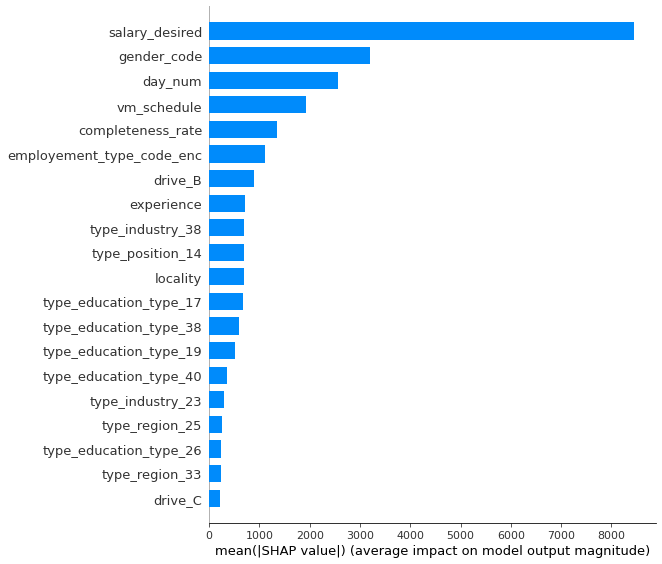

In [57]:
import shap
import matplotlib.pyplot as plt
f = plt.figure()
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

In [42]:

X_test = test[[ 'day_year','weekday','employement_type_code_enc', 
              'neprd_schedule','nrd_schedule','gg_schedule','cg_schedule','prd_schedule',
              'vm_schedule','employement_type_code','day_num', 'id', 'type_education_type_0',
       'type_education_type_1', 'type_education_type_2',
       'type_education_type_3', 'type_education_type_4',
       'type_education_type_5', 'type_education_type_6',
       'type_education_type_7', 'type_education_type_8',
       'type_education_type_9', 'type_education_type_10',
       'type_education_type_11', 'type_education_type_12',
       'type_education_type_13', 'type_education_type_14',
       'type_education_type_15', 'type_education_type_16',
       'type_education_type_17', 'type_education_type_18',
       'type_education_type_19', 'type_education_type_20',
       'type_education_type_21', 'type_education_type_22',
       'type_education_type_23', 'type_education_type_24',
       'type_education_type_25', 'type_education_type_26',
       'type_education_type_27', 'type_education_type_28',
       'type_education_type_29', 'type_education_type_30',
       'type_education_type_31', 'type_education_type_32',
       'type_education_type_33', 'type_education_type_34',
       'type_education_type_35', 'type_education_type_36',
       'type_education_type_37', 'type_education_type_38',
       'type_education_type_39', 'type_education_type_40',
       'type_education_type_41', 'type_education_type_42',
       'type_education_type_43', 'type_education_type_44',
       'type_education_type_45', 'type_education_type_46',
       'type_education_type_47', 'type_education_type_48',
       'type_education_type_49', 'type_locality_name_0',
       'type_locality_name_1', 'type_locality_name_2',
       'type_locality_name_3', 'type_locality_name_4',
       'type_locality_name_5', 'type_locality_name_6',
       'type_locality_name_7', 'type_locality_name_8',
       'type_locality_name_9', 'type_locality_name_10',
       'type_locality_name_11', 'type_locality_name_12',
       'type_locality_name_13', 'type_locality_name_14',
       'type_locality_name_15', 'type_locality_name_16',
       'type_locality_name_17', 'type_locality_name_18',
       'type_locality_name_19', 'type_locality_name_20',
       'type_locality_name_21', 'type_locality_name_22',
       'type_locality_name_23', 'type_locality_name_24',
       'type_locality_name_25', 'type_locality_name_26',
       'type_locality_name_27', 'type_locality_name_28',
       'type_locality_name_29', 'type_locality_name_30',
       'type_locality_name_31', 'type_locality_name_32',
       'type_locality_name_33', 'type_locality_name_34',
       'type_locality_name_35', 'type_locality_name_36',
       'type_locality_name_37', 'type_locality_name_38',
       'type_locality_name_39', 'type_locality_name_40',
       'type_locality_name_41', 'type_locality_name_42',
       'type_locality_name_43', 'type_locality_name_44',
       'type_locality_name_45', 'type_locality_name_46',
       'type_locality_name_47', 'type_locality_name_48',
       'type_locality_name_49', 'type_industry_0',
       'type_industry_1', 'type_industry_2', 'type_industry_3',
       'type_industry_4', 'type_industry_5', 'type_industry_6',
       'type_industry_7', 'type_industry_8', 'type_industry_9',
       'type_industry_10', 'type_industry_11', 'type_industry_12',
       'type_industry_13', 'type_industry_14', 'type_industry_15',
       'type_industry_16', 'type_industry_17', 'type_industry_18',
       'type_industry_19', 'type_industry_20', 'type_industry_21',
       'type_industry_22', 'type_industry_23', 'type_industry_24',
       'type_industry_25', 'type_industry_26', 'type_industry_27',
       'type_industry_28', 'type_industry_29', 'type_industry_30',
       'type_industry_31', 'type_industry_32', 'type_industry_33',
       'type_industry_34', 'type_industry_35', 'type_industry_36',
       'type_industry_37', 'type_industry_38', 'type_industry_39',
       'type_industry_40', 'type_industry_41', 'type_industry_42',
       'type_industry_43', 'type_industry_44', 'type_industry_45',
       'type_industry_46', 'type_industry_47', 'type_industry_48',
       'type_industry_49', 'type_region_0', 'type_region_1',
       'type_region_2', 'type_region_3', 'type_region_4', 'type_region_5',
       'type_region_6', 'type_region_7', 'type_region_8', 'type_region_9',
       'type_region_10', 'type_region_11', 'type_region_12',
       'type_region_13', 'type_region_14', 'type_region_15',
       'type_region_16', 'type_region_17', 'type_region_18',
       'type_region_19', 'type_region_20', 'type_region_21',
       'type_region_22', 'type_region_23', 'type_region_24',
       'type_region_25', 'type_region_26', 'type_region_27',
       'type_region_28', 'type_region_29', 'type_region_30',
       'type_region_31', 'type_region_32', 'type_region_33',
       'type_region_34', 'type_region_35', 'type_region_36',
       'type_region_37', 'type_region_38', 'type_region_39',
       'type_region_40', 'type_region_41', 'type_region_42',
       'type_region_43', 'type_region_44', 'type_region_45',
       'type_region_46', 'type_region_47', 'type_region_48',
       'type_region_49', 'type_position_0', 'type_position_1',
       'type_position_2', 'type_position_3', 'type_position_4',
       'type_position_5', 'type_position_6', 'type_position_7',
       'type_position_8', 'type_position_9', 'type_position_10',
       'type_position_11', 'type_position_12', 'type_position_13',
       'type_position_14', 'type_position_15', 'type_position_16',
       'type_position_17', 'type_position_18', 'type_position_19',
       'type_position_20', 'type_position_21', 'type_position_22',
       'type_position_23', 'type_position_24', 'type_position_25',
       'type_position_26', 'type_position_27', 'type_position_28',
       'type_position_29', 'type_position_30', 'type_position_31',
       'type_position_32', 'type_position_33', 'type_position_34',
       'type_position_35', 'type_position_36', 'type_position_37',
       'type_position_38', 'type_position_39', 'type_position_40',
       'type_position_41', 'type_position_42', 'type_position_43',
       'type_position_44', 'type_position_45', 'type_position_46',
       'type_position_47', 'type_position_48', 'type_position_49',
       'locality', 'age', 'experience',
       'salary_desired',
        'completeness_rate', 'citizenship_code',
       'gender_code', 'drive_A', 'drive_B', 'drive_C', 'drive_D',
       'drive_E', 'pub_year', 'pub_month', 'pub_day']]
# 'del_mod_cre', 'del_mod_pub',
X_test.pub_year = X_test.pub_year.astype('int64')
X_test.pub_month = X_test.pub_month.astype('int64')
X_test.pub_day = X_test.pub_day.astype('int64')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131259 entries, 0 to 131258
Columns: 277 entries, day_year to pub_day
dtypes: float64(254), int64(23)
memory usage: 278.4 MB


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [31]:

data = train[[ 'day_year','weekday','employement_type_code_enc', 
              'neprd_schedule','nrd_schedule','gg_schedule','cg_schedule','prd_schedule',
              'vm_schedule','employement_type_code','day_num', 'id', 'type_education_type_0',
              'type_institution_0', 'type_institution_1',
       'type_institution_2', 'type_institution_3', 'type_institution_4',
       'type_institution_5', 'type_institution_6', 'type_institution_7',
       'type_institution_8', 'type_institution_9', 'type_institution_10',
       'type_institution_11', 'type_institution_12',
       'type_institution_13', 'type_institution_14',
       'type_institution_15', 'type_institution_16',
       'type_institution_17', 'type_institution_18',
       'type_institution_19', 'type_institution_20',
       'type_institution_21', 'type_institution_22',
       'type_institution_23', 'type_institution_24',
       'type_institution_25', 'type_institution_26',
       'type_institution_27', 'type_institution_28',
       'type_institution_29', 'type_institution_30',
       'type_institution_31', 'type_institution_32',
       'type_institution_33', 'type_institution_34',
       'type_institution_35', 'type_institution_36',
       'type_institution_37', 'type_institution_38',
       'type_institution_39', 'type_institution_40',
       'type_institution_41', 'type_institution_42',
       'type_institution_43', 'type_institution_44',
       'type_institution_45', 'type_institution_46',
       'type_institution_47', 'type_institution_48',
       'type_institution_49',
       'type_schedule_employement_type_0',
       'type_schedule_employement_type_1',
       'type_schedule_employement_type_2',
       'type_schedule_employement_type_3',
       'type_schedule_employement_type_4',
       'type_schedule_employement_type_5',
       'type_schedule_employement_type_6',
       'type_schedule_employement_type_7',
       'type_schedule_employement_type_8',
       'type_schedule_employement_type_9',
       'type_schedule_employement_type_10',
       'type_schedule_employement_type_11',
       'type_schedule_employement_type_12',
       'type_schedule_employement_type_13',
       'type_schedule_employement_type_14',
       'type_schedule_employement_type_15',
       'type_schedule_employement_type_16',
       'type_schedule_employement_type_17',
       'type_schedule_employement_type_18',
       'type_schedule_employement_type_19',
       'type_schedule_employement_type_20',
       'type_schedule_employement_type_21',
       'type_schedule_employement_type_22',
       'type_schedule_employement_type_23',
       'type_schedule_employement_type_24',
       'type_schedule_employement_type_25',
       'type_schedule_employement_type_26',
       'type_schedule_employement_type_27',
       'type_schedule_employement_type_28',
       'type_schedule_employement_type_29',
       'type_schedule_employement_type_30',
       'type_schedule_employement_type_31',
       'type_schedule_employement_type_32',
       'type_schedule_employement_type_33',
       'type_schedule_employement_type_34',
       'type_schedule_employement_type_35',
       'type_schedule_employement_type_36',
       'type_schedule_employement_type_37',
       'type_schedule_employement_type_38',
       'type_schedule_employement_type_39',
       'type_schedule_employement_type_40',
       'type_schedule_employement_type_41',
       'type_schedule_employement_type_42',
       'type_schedule_employement_type_43',
       'type_schedule_employement_type_44',
       'type_schedule_employement_type_45',
       'type_schedule_employement_type_46',
       'type_schedule_employement_type_47',
       'type_schedule_employement_type_48',
       'type_schedule_employement_type_49', 
       'type_region_locality_name_0', 'type_region_locality_name_1',
       'type_region_locality_name_2', 'type_region_locality_name_3',
       'type_region_locality_name_4', 'type_region_locality_name_5',
       'type_region_locality_name_6', 'type_region_locality_name_7',
       'type_region_locality_name_8', 'type_region_locality_name_9',
       'type_region_locality_name_10', 'type_region_locality_name_11',
       'type_region_locality_name_12', 'type_region_locality_name_13',
       'type_region_locality_name_14', 'type_region_locality_name_15',
       'type_region_locality_name_16', 'type_region_locality_name_17',
       'type_region_locality_name_18', 'type_region_locality_name_19',
       'type_region_locality_name_20', 'type_region_locality_name_21',
       'type_region_locality_name_22', 'type_region_locality_name_23',
       'type_region_locality_name_24', 'type_region_locality_name_25',
       'type_region_locality_name_26', 'type_region_locality_name_27',
       'type_region_locality_name_28', 'type_region_locality_name_29',
       'type_region_locality_name_30', 'type_region_locality_name_31',
       'type_region_locality_name_32', 'type_region_locality_name_33',
       'type_region_locality_name_34', 'type_region_locality_name_35',
       'type_region_locality_name_36', 'type_region_locality_name_37',
       'type_region_locality_name_38', 'type_region_locality_name_39',
       'type_region_locality_name_40', 'type_region_locality_name_41',
       'type_region_locality_name_42', 'type_region_locality_name_43',
       'type_region_locality_name_44', 'type_region_locality_name_45',
       'type_region_locality_name_46', 'type_region_locality_name_47',
       'type_region_locality_name_48', 'type_region_locality_name_49',
       'type_position_industry_region_locality_0',
       'type_position_industry_region_locality_1',
       'type_position_industry_region_locality_2',
       'type_position_industry_region_locality_3',
       'type_position_industry_region_locality_4',
       'type_position_industry_region_locality_5',
       'type_position_industry_region_locality_6',
       'type_position_industry_region_locality_7',
       'type_position_industry_region_locality_8',
       'type_position_industry_region_locality_9',
       'type_position_industry_region_locality_10',
       'type_position_industry_region_locality_11',
       'type_position_industry_region_locality_12',
       'type_position_industry_region_locality_13',
       'type_position_industry_region_locality_14',
       'type_position_industry_region_locality_15',
       'type_position_industry_region_locality_16',
       'type_position_industry_region_locality_17',
       'type_position_industry_region_locality_18',
       'type_position_industry_region_locality_19',
       'type_position_industry_region_locality_20',
       'type_position_industry_region_locality_21',
       'type_position_industry_region_locality_22',
       'type_position_industry_region_locality_23',
       'type_position_industry_region_locality_24',
       'type_position_industry_region_locality_25',
       'type_position_industry_region_locality_26',
       'type_position_industry_region_locality_27',
       'type_position_industry_region_locality_28',
       'type_position_industry_region_locality_29',
       'type_position_industry_region_locality_30',
       'type_position_industry_region_locality_31',
       'type_position_industry_region_locality_32',
       'type_position_industry_region_locality_33',
       'type_position_industry_region_locality_34',
       'type_position_industry_region_locality_35',
       'type_position_industry_region_locality_36',
       'type_position_industry_region_locality_37',
       'type_position_industry_region_locality_38',
       'type_position_industry_region_locality_39',
       'type_position_industry_region_locality_40',
       'type_position_industry_region_locality_41',
       'type_position_industry_region_locality_42',
       'type_position_industry_region_locality_43',
       'type_position_industry_region_locality_44',
       'type_position_industry_region_locality_45',
       'type_position_industry_region_locality_46',
       'type_position_industry_region_locality_47',
       'type_position_industry_region_locality_48',
       'type_position_industry_region_locality_49',
       'type_position_industry_region_0',
       'type_position_industry_region_1',
       'type_position_industry_region_2',
       'type_position_industry_region_3',
       'type_position_industry_region_4',
       'type_position_industry_region_5',
       'type_position_industry_region_6',
       'type_position_industry_region_7',
       'type_position_industry_region_8',
       'type_position_industry_region_9',
       'type_position_industry_region_10',
       'type_position_industry_region_11',
       'type_position_industry_region_12',
       'type_position_industry_region_13',
       'type_position_industry_region_14',
       'type_position_industry_region_15',
       'type_position_industry_region_16',
       'type_position_industry_region_17',
       'type_position_industry_region_18',
       'type_position_industry_region_19',
       'type_position_industry_region_20',
       'type_position_industry_region_21',
       'type_position_industry_region_22',
       'type_position_industry_region_23',
       'type_position_industry_region_24',
       'type_position_industry_region_25',
       'type_position_industry_region_26',
       'type_position_industry_region_27',
       'type_position_industry_region_28',
       'type_position_industry_region_29',
       'type_position_industry_region_30',
       'type_position_industry_region_31',
       'type_position_industry_region_32',
       'type_position_industry_region_33',
       'type_position_industry_region_34',
       'type_position_industry_region_35',
       'type_position_industry_region_36',
       'type_position_industry_region_37',
       'type_position_industry_region_38',
       'type_position_industry_region_39',
       'type_position_industry_region_40',
       'type_position_industry_region_41',
       'type_position_industry_region_42',
       'type_position_industry_region_43',
       'type_position_industry_region_44',
       'type_position_industry_region_45',
       'type_position_industry_region_46',
       'type_position_industry_region_47',
       'type_position_industry_region_48',
       'type_position_industry_region_49',
       'type_position_industry_0', 'type_position_industry_1',
       'type_position_industry_2', 'type_position_industry_3',
       'type_position_industry_4', 'type_position_industry_5',
       'type_position_industry_6', 'type_position_industry_7',
       'type_position_industry_8', 'type_position_industry_9',
       'type_position_industry_10', 'type_position_industry_11',
       'type_position_industry_12', 'type_position_industry_13',
       'type_position_industry_14', 'type_position_industry_15',
       'type_position_industry_16', 'type_position_industry_17',
       'type_position_industry_18', 'type_position_industry_19',
       'type_position_industry_20', 'type_position_industry_21',
       'type_position_industry_22', 'type_position_industry_23',
       'type_position_industry_24', 'type_position_industry_25',
       'type_position_industry_26', 'type_position_industry_27',
       'type_position_industry_28', 'type_position_industry_29',
       'type_position_industry_30', 'type_position_industry_31',
       'type_position_industry_32', 'type_position_industry_33',
       'type_position_industry_34', 'type_position_industry_35',
       'type_position_industry_36', 'type_position_industry_37',
       'type_position_industry_38', 'type_position_industry_39',
       'type_position_industry_40', 'type_position_industry_41',
       'type_position_industry_42', 'type_position_industry_43',
       'type_position_industry_44', 'type_position_industry_45',
       'type_position_industry_46', 'type_position_industry_47',
       'type_position_industry_48', 'type_position_industry_49',
       'type_education_type_1', 'type_education_type_2',
       'type_education_type_3', 'type_education_type_4',
       'type_education_type_5', 'type_education_type_6',
       'type_education_type_7', 'type_education_type_8',
       'type_education_type_9', 'type_education_type_10',
       'type_education_type_11', 'type_education_type_12',
       'type_education_type_13', 'type_education_type_14',
       'type_education_type_15', 'type_education_type_16',
       'type_education_type_17', 'type_education_type_18',
       'type_education_type_19', 'type_education_type_20',
       'type_education_type_21', 'type_education_type_22',
       'type_education_type_23', 'type_education_type_24',
       'type_education_type_25', 'type_education_type_26',
       'type_education_type_27', 'type_education_type_28',
       'type_education_type_29', 'type_education_type_30',
       'type_education_type_31', 'type_education_type_32',
       'type_education_type_33', 'type_education_type_34',
       'type_education_type_35', 'type_education_type_36',
       'type_education_type_37', 'type_education_type_38',
       'type_education_type_39', 'type_education_type_40',
       'type_education_type_41', 'type_education_type_42',
       'type_education_type_43', 'type_education_type_44',
       'type_education_type_45', 'type_education_type_46',
       'type_education_type_47', 'type_education_type_48',
       'type_education_type_49', 'type_locality_name_0',
       'type_locality_name_1', 'type_locality_name_2',
       'type_locality_name_3', 'type_locality_name_4',
       'type_locality_name_5', 'type_locality_name_6',
       'type_locality_name_7', 'type_locality_name_8',
       'type_locality_name_9', 'type_locality_name_10',
       'type_locality_name_11', 'type_locality_name_12',
       'type_locality_name_13', 'type_locality_name_14',
       'type_locality_name_15', 'type_locality_name_16',
       'type_locality_name_17', 'type_locality_name_18',
       'type_locality_name_19', 'type_locality_name_20',
       'type_locality_name_21', 'type_locality_name_22',
       'type_locality_name_23', 'type_locality_name_24',
       'type_locality_name_25', 'type_locality_name_26',
       'type_locality_name_27', 'type_locality_name_28',
       'type_locality_name_29', 'type_locality_name_30',
       'type_locality_name_31', 'type_locality_name_32',
       'type_locality_name_33', 'type_locality_name_34',
       'type_locality_name_35', 'type_locality_name_36',
       'type_locality_name_37', 'type_locality_name_38',
       'type_locality_name_39', 'type_locality_name_40',
       'type_locality_name_41', 'type_locality_name_42',
       'type_locality_name_43', 'type_locality_name_44',
       'type_locality_name_45', 'type_locality_name_46',
       'type_locality_name_47', 'type_locality_name_48',
       'type_locality_name_49', 'type_industry_0',
       'type_industry_1', 'type_industry_2', 'type_industry_3',
       'type_industry_4', 'type_industry_5', 'type_industry_6',
       'type_industry_7', 'type_industry_8', 'type_industry_9',
       'type_industry_10', 'type_industry_11', 'type_industry_12',
       'type_industry_13', 'type_industry_14', 'type_industry_15',
       'type_industry_16', 'type_industry_17', 'type_industry_18',
       'type_industry_19', 'type_industry_20', 'type_industry_21',
       'type_industry_22', 'type_industry_23', 'type_industry_24',
       'type_industry_25', 'type_industry_26', 'type_industry_27',
       'type_industry_28', 'type_industry_29', 'type_industry_30',
       'type_industry_31', 'type_industry_32', 'type_industry_33',
       'type_industry_34', 'type_industry_35', 'type_industry_36',
       'type_industry_37', 'type_industry_38', 'type_industry_39',
       'type_industry_40', 'type_industry_41', 'type_industry_42',
       'type_industry_43', 'type_industry_44', 'type_industry_45',
       'type_industry_46', 'type_industry_47', 'type_industry_48',
       'type_industry_49', 'type_region_0', 'type_region_1',
       'type_region_2', 'type_region_3', 'type_region_4', 'type_region_5',
       'type_region_6', 'type_region_7', 'type_region_8', 'type_region_9',
       'type_region_10', 'type_region_11', 'type_region_12',
       'type_region_13', 'type_region_14', 'type_region_15',
       'type_region_16', 'type_region_17', 'type_region_18',
       'type_region_19', 'type_region_20', 'type_region_21',
       'type_region_22', 'type_region_23', 'type_region_24',
       'type_region_25', 'type_region_26', 'type_region_27',
       'type_region_28', 'type_region_29', 'type_region_30',
       'type_region_31', 'type_region_32', 'type_region_33',
       'type_region_34', 'type_region_35', 'type_region_36',
       'type_region_37', 'type_region_38', 'type_region_39',
       'type_region_40', 'type_region_41', 'type_region_42',
       'type_region_43', 'type_region_44', 'type_region_45',
       'type_region_46', 'type_region_47', 'type_region_48',
       'type_region_49', 'type_position_0', 'type_position_1',
       'type_position_2', 'type_position_3', 'type_position_4',
       'type_position_5', 'type_position_6', 'type_position_7',
       'type_position_8', 'type_position_9', 'type_position_10',
       'type_position_11', 'type_position_12', 'type_position_13',
       'type_position_14', 'type_position_15', 'type_position_16',
       'type_position_17', 'type_position_18', 'type_position_19',
       'type_position_20', 'type_position_21', 'type_position_22',
       'type_position_23', 'type_position_24', 'type_position_25',
       'type_position_26', 'type_position_27', 'type_position_28',
       'type_position_29', 'type_position_30', 'type_position_31',
       'type_position_32', 'type_position_33', 'type_position_34',
       'type_position_35', 'type_position_36', 'type_position_37',
       'type_position_38', 'type_position_39', 'type_position_40',
       'type_position_41', 'type_position_42', 'type_position_43',
       'type_position_44', 'type_position_45', 'type_position_46',
       'type_position_47', 'type_position_48', 'type_position_49',
       'locality', 'age', 'experience',
       'salary_desired',
        'completeness_rate', 'salary', 'citizenship_code',
       'gender_code', 'drive_A', 'drive_B', 'drive_C', 'drive_D',
       'drive_E', 'pub_year', 'pub_month', 'pub_day']]
# 'del_mod_cre', 'del_mod_pub',
data.pub_year = data.pub_year.astype('int64')
data.pub_month = data.pub_month.astype('int64')
data.pub_day = data.pub_day.astype('int64')
data.info()
data.age = data.age.fillna(data.age.median())
data.completeness_rate = data.completeness_rate.fillna(data.completeness_rate.median())
data.dropna()

,day_year,weekday,employement_type_code_enc,neprd_schedule,nrd_schedule,gg_schedule,cg_schedule,prd_schedule,vm_schedule,employement_type_code,...,citizenship_code,gender_code,drive_A,drive_B,drive_C,drive_D,drive_E,pub_year,pub_month,pub_day
0,128,4,1.212138,0,0,0,0,1,0,1,...,9,2,0,1,0,0,0,2020,5,7
1,301,2,1.136578,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2020,10,27
2,35,2,1.077922,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2020,2,4
3,263,6,1.276699,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2020,9,19
4,112,2,1.185788,0,0,0,0,1,0,1,...,9,2,0,0,0,0,0,2020,4,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300699,125,1,1.000000,0,0,0,1,1,0,1,...,9,2,0,0,0,0,0,2020,5,4
300700,111,1,1.094972,0,0,0,0,1,0,1,...,9,2,0,1,1,0,0,2020,4,20
300701,343,4,1.160000,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2016,12,8
300702,154,2,1.093802,0,0,0,0,1,0,1,...,9,1,0,1,0,0,0,2020,6,2
